<a href="https://colab.research.google.com/github/DATAITINA/my-ai-journey/blob/main/Sign_Lang_using_gTTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow opencv-python mediapipe gTTS
!apt-get update

from google.colab import drive
drive.mount('/content/drive')

import cv2
import mediapipe as mp
import tensorflow as tf
import numpy as np
from gtts import gTTS
from IPython.display import display, Javascript, HTML, Audio
from google.colab.output import eval_js, register_callback
from base64 import b64decode
import matplotlib.pyplot as plt
import time
import tempfile

print("📦 Libraries imported successfully!")

def load_model(model_path="/content/drive/MyDrive/best_model_2.h5"):
    try:
        model = tf.keras.models.load_model(model_path)
        print(f"✅ Model loaded! Input shape: {model.input_shape}")
        return model
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

model = load_model()

CLASSES = ["Good morning", "How are you", "What's up",
           "I'm sorry", "Take care", "Thank you", "You're welcome"]

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.3,
    min_tracking_confidence=0.5
)

def speak_text(text):
    """Convert text to speech and play in Colab"""
    try:
        tts = gTTS(text=text, lang="en")
        with tempfile.NamedTemporaryFile(delete=False, suffix=".mp3") as tmp:
            tts.save(tmp.name)
            display(Audio(tmp.name, autoplay=True))
        print(f"🔊 Spoke: {text}")
    except Exception as e:
        print(f"🔊 TTS error: {e}")

# Register callback for manual button
def speakPrediction(pred_text):
    speak_text(pred_text)

register_callback('speakPrediction', speakPrediction)

def speak_button(prediction):
    """Create a Speak button in Colab"""
    return HTML(f"""
    <button onclick="google.colab.kernel.invokeFunction('speakPrediction', ['{prediction}'], {{}})"
            style="background:#4CAF50;color:white;padding:10px 20px;
                   border:none;border-radius:5px;cursor:pointer;">
        🔊 Speak "{prediction}"
    </button>
    """)

print("Setup completed!")

def preprocess_for_model(image, results=None):
    """Preprocess image for model prediction"""
    if results and results.multi_hand_landmarks:
        h, w = image.shape[:2]
        x_min, y_min, x_max, y_max = w, h, 0, 0
        for hand_landmarks in results.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                x_min, y_min = min(x_min, x), min(y_min, y)
                x_max, y_max = max(x_max, x), max(y_max, y)
        padding = 20
        x_min, y_min = max(0, x_min - padding), max(0, y_min - padding)
        x_max, y_max = min(w, x_max + padding), min(h, y_max + padding)
        cropped = image[y_min:y_max, x_min:x_max]
        if cropped.size == 0:
            cropped = image
    else:
        cropped = image
    resized = cv2.resize(cropped, (224, 224))
    normalized = resized.astype('float32') / 255.0
    return np.expand_dims(normalized, axis=0)

def detect_hands_and_predict(frame):
    """Detect hands and make predictions"""
    if frame is None:
        return None, "No frame", 0.0

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=4),
                mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
            )

        processed_img = preprocess_for_model(rgb_frame, results)
        predictions = model.predict(processed_img, verbose=0)
        predicted_idx = np.argmax(predictions[0])
        confidence = float(predictions[0][predicted_idx])

        if predicted_idx < len(CLASSES):
            predicted_sign = CLASSES[predicted_idx]
            return frame, predicted_sign, confidence

    return frame, "No hands detected", 0.0

def take_photo_js(filename='capture.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = '📸 Capture Photo';
      capture.style = "background:#4CAF50;color:white;padding:10px;margin:10px;font-size:16px;border:none;border-radius:5px;";
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      video.style.maxWidth = '500px';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def process_single_capture():
    print("Camera will open below. Click 'Capture Photo' when ready!")
    try:
        filename = take_photo_js()
        frame = cv2.imread(filename)
        if frame is None:
            print("❌ Failed to load captured image")
            return
        annotated_frame, prediction, confidence = detect_hands_and_predict(frame)

        print(f"\n🤟 Prediction: {prediction}")
        print(f"📊 Confidence: {confidence:.2f}")

        if confidence > 0.5 and prediction != "No hands detected":
            speak_text(prediction)

        display(speak_button(prediction))

        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Prediction: {prediction} (Confidence: {confidence:.2f})")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"❌ Error: {e}")


INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 22.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires pro

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://cli.github.com/packages stable/main amd64 Packages [346 B]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,336 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,274 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [5,526 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packag

✅ Model loaded! Input shape: (None, 224, 224, 3)
Setup completed!


Camera will open below. Click 'Capture Photo' when ready!


<IPython.core.display.Javascript object>


🤟 Prediction: You're welcome
📊 Confidence: 1.00


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


🔊 Spoke: You're welcome


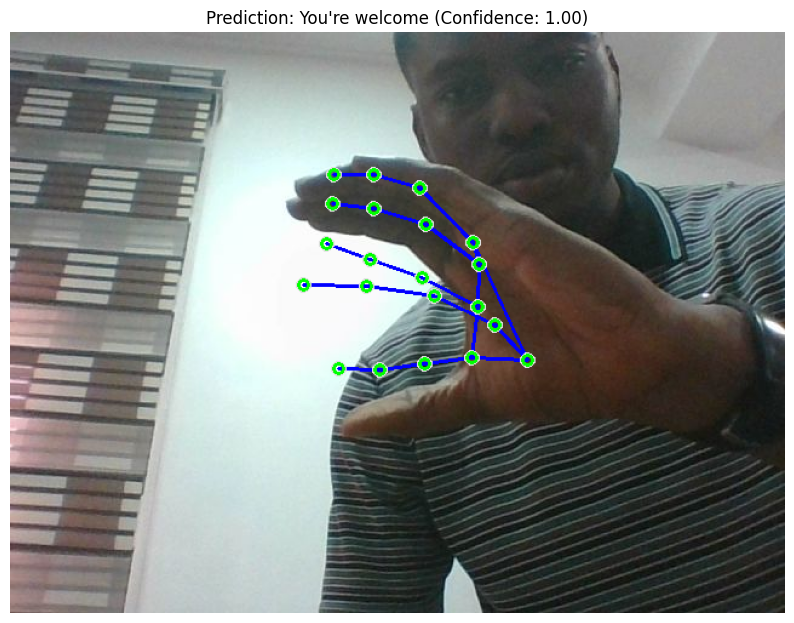

In [ ]:
process_single_capture()